<font color="#CC3D3D"><p>
# Build models

- `INPUT`: 학습용(`X_train.csv`, `y_train`)과 평가용(`X_test.csv`) 데이터 
- `OUTPUT`: 위 데이터를 이용하여 구축한 모형이 생성한 예측결과(`submission.csv`)

##### Imports

In [8]:
# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# EDA`
import klib

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.base import ClassifierMixin


# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

### 1. Read Data

In [2]:
# 학습용과 평가용(제출용) 데이터를 읽어들인다.
train = pd.read_csv(os.path.abspath("../dat")+'/X_train.csv', encoding='cp949')
test = pd.read_csv(os.path.abspath("../dat")+'/X_test.csv', encoding='cp949')

# 분석에 필요없는 ID 필드를 데이터에서 제거하고, 전처리 후 학습용과 제출용 데이터를 분리하기 위해 ID는 보관한다.
train_id = train['cust_id']
test_id = test['cust_id']
del train['cust_id'], test['cust_id']

# 학습용 정답 데이터를 읽는다.
y_train = pd.read_csv(os.path.abspath("../dat")+'/y_train.csv', encoding='cp949').gender

# 전처리를 동일하게 적용하기 위해 두 데이터를 합한다.
features = pd.concat([train, test]).reset_index(drop=True)
features

,총구매액,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,...,recommend_items,고가상품최다빈도품목,최대지출품목,Top5상품구매건수,선호시즌,다양한 제품 보유 지점 선호도,목적지향적 물품 소비율,내점시마다 구매액의 일관성,총초고가상품구매액,초고가상품구매율
0,68282840,922741,11264000,35,28,17,19,17,0.527027,0.094595,...,농산가공,화장품,화장품,31,이사/혼수시즌,98.0,0.000000,1.967007e+13,51378500.0,0.752436
1,2136000,712000,2136000,2,2,2,2,1,0.000000,0.000000,...,시티캐주얼,트래디셔널,트래디셔널,0,이사/혼수시즌,16.0,0.000000,5.898240e+11,NaN,NaN
2,3197000,799250,1639000,1,2,2,2,1,0.000000,0.000000,...,비지니스군,남성 캐주얼,남성 캐주얼,2,기타,4.0,0.000000,1.322500e+10,NaN,NaN
3,16077620,365400,4935000,24,20,13,18,16,0.318182,0.590909,...,햄,캐주얼,침구/수예,16,이사/혼수시즌,90.0,0.000000,2.298187e+12,9410000.0,0.585286
4,29050000,9683333,24000000,2,3,3,2,85,0.000000,0.333333,...,시니어,보석,보석,2,기타,16.0,0.333333,1.556256e+14,27000000.0,0.929432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,82581500,5898679,23976000,8,7,7,8,40,0.642857,0.071429,...,시티웨어,골프,시티웨어,4,기타,NaN,0.000000,7.131591e+13,69236000.0,0.838396
5978,480000,480000,480000,1,1,1,1,0,0.000000,0.000000,...,니 트,NaN,섬유잡화,0,기타,NaN,0.000000,0.000000e+00,NaN,NaN
5979,260003790,3662025,25750000,38,28,19,19,18,0.915493,0.154930,...,기초 화장품,남성 캐주얼,남성 캐주얼,8,기타,NaN,0.098592,1.418008e+14,208682400.0,0.802613
5980,88991520,4943973,18120000,9,7,5,5,60,0.444444,0.277778,...,일반가공식품,육류,육류,0,이사/혼수시즌,NaN,0.000000,5.815031e+13,75490300.0,0.848286


### 2. EDA

In [3]:
#matplotlib 한글깨짐 지원

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)  

GridSpec(6, 6)

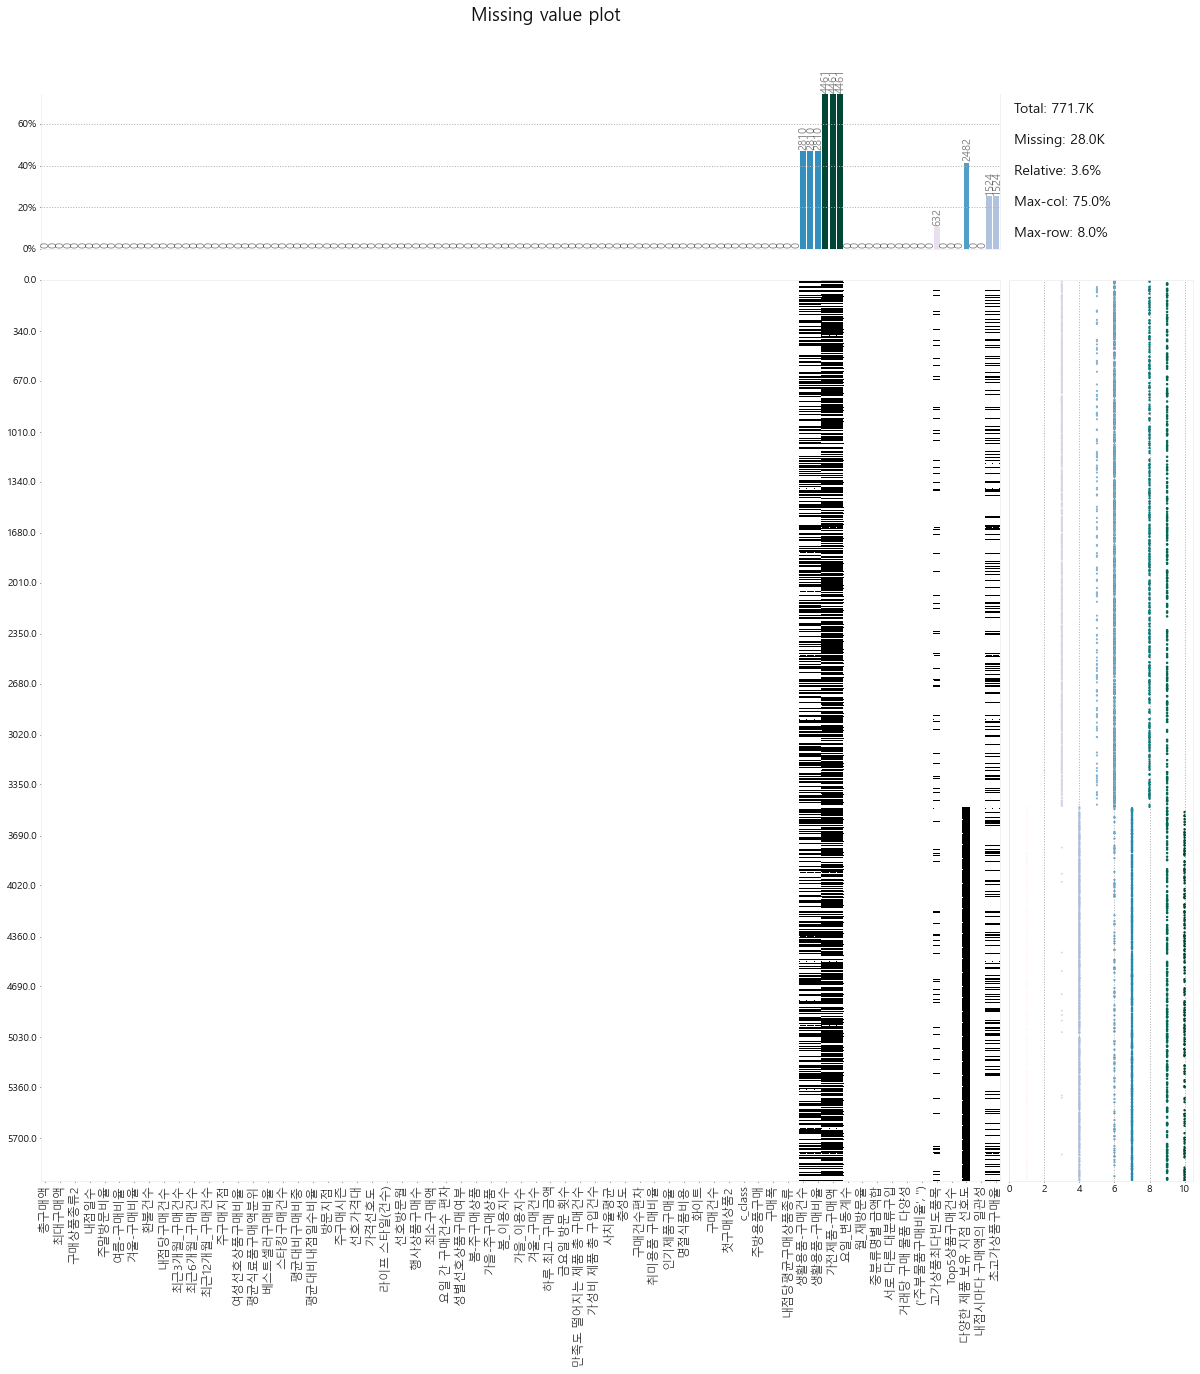

In [4]:
# 결측값 파악

klib.missingval_plot(features)

Note: The number of non binary numerical features is very large (103), please consider splitting the data. Showing plots for the first 20 numerical features. Override this by setting showall=True.


<AxesSubplot:xlabel='최근6개월_구매금액', ylabel='Density'>

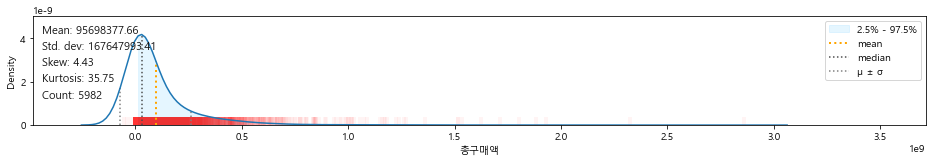

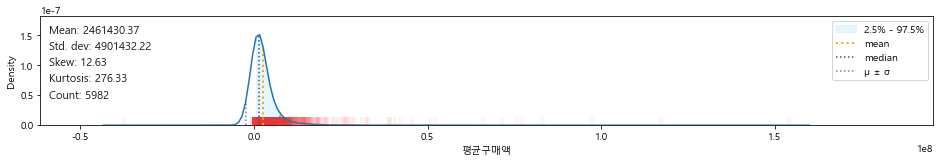

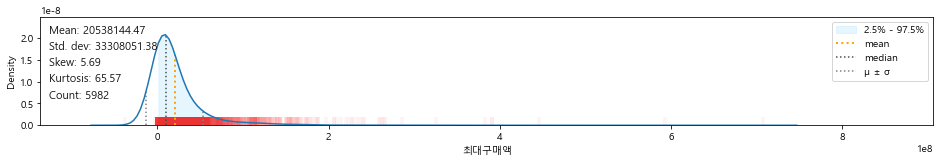

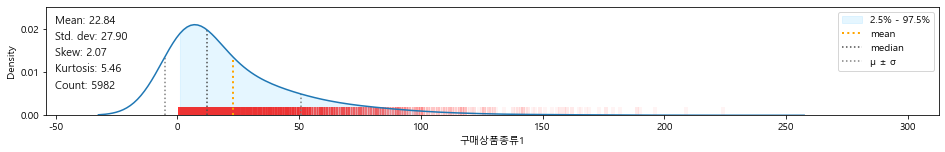

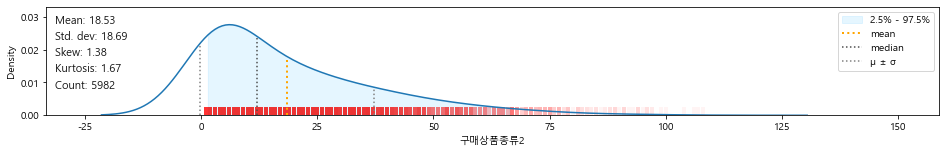

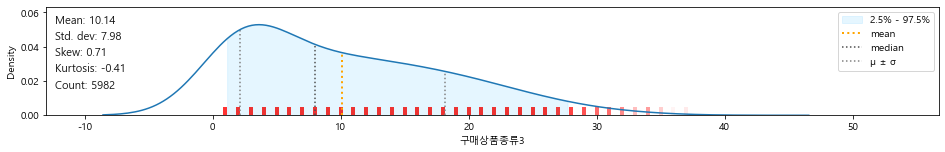

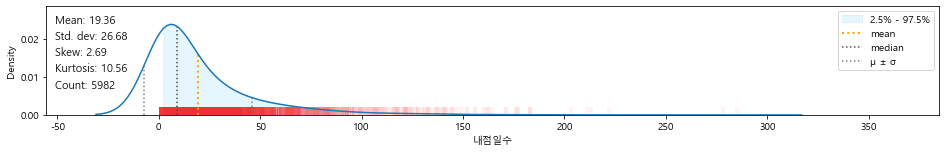

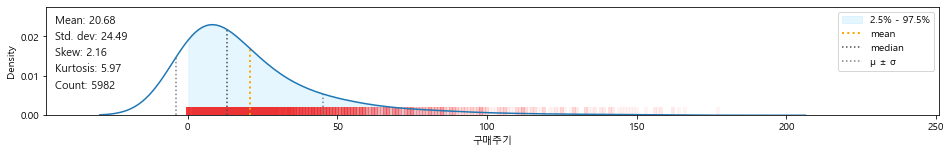

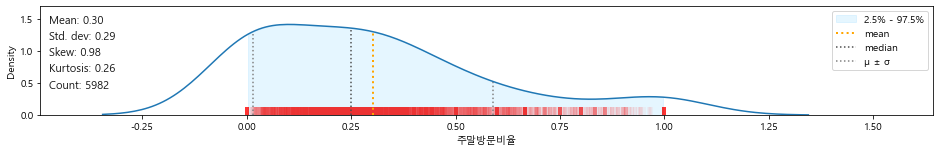

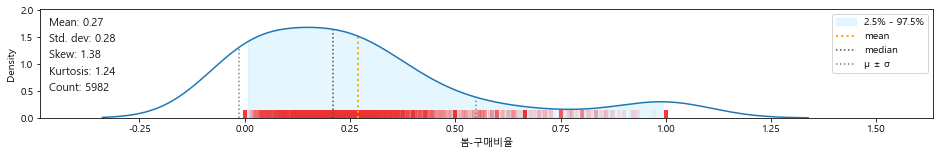

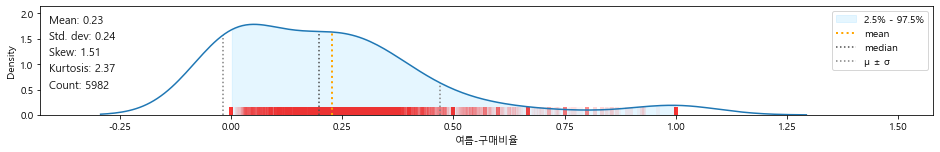

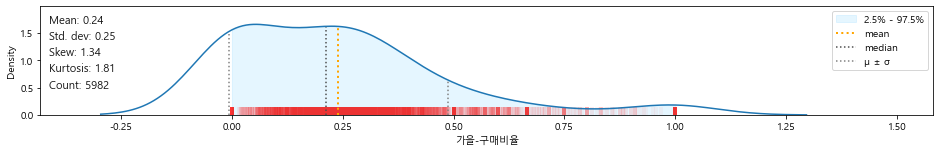

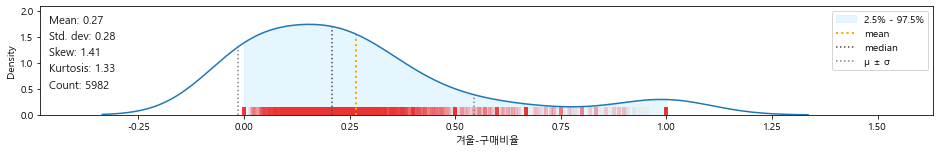

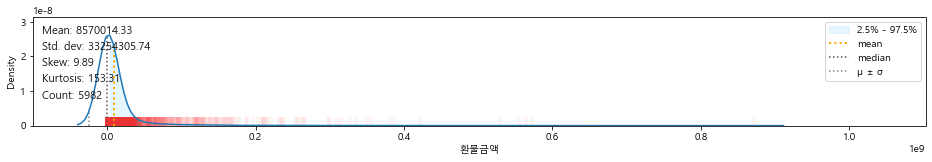

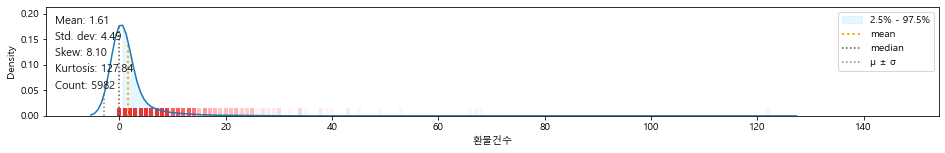

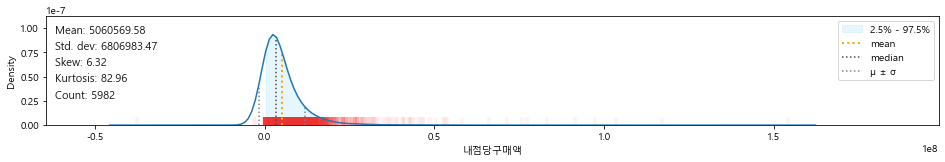

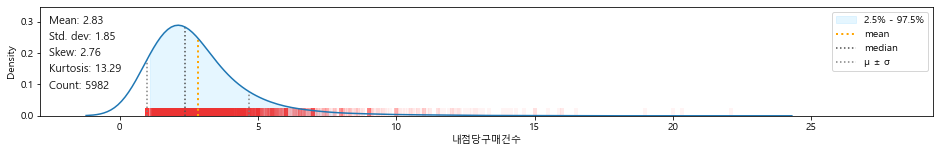

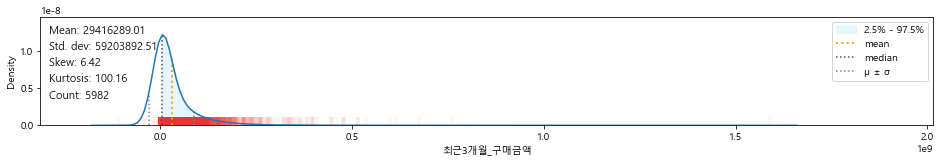

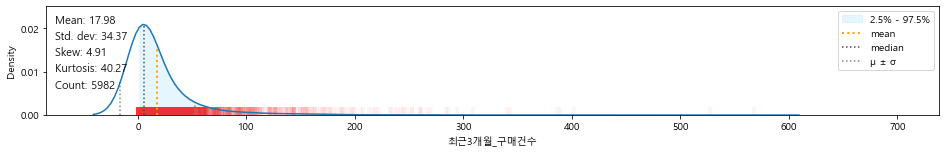

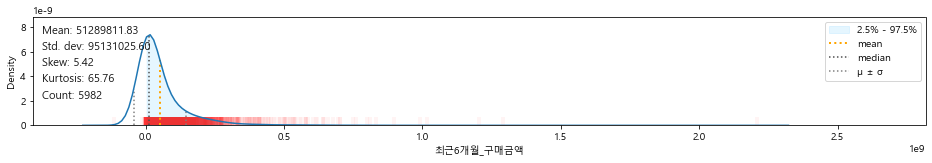

In [5]:
# 수치형 속성 파악

klib.dist_plot(features)

GridSpec(6, 23)

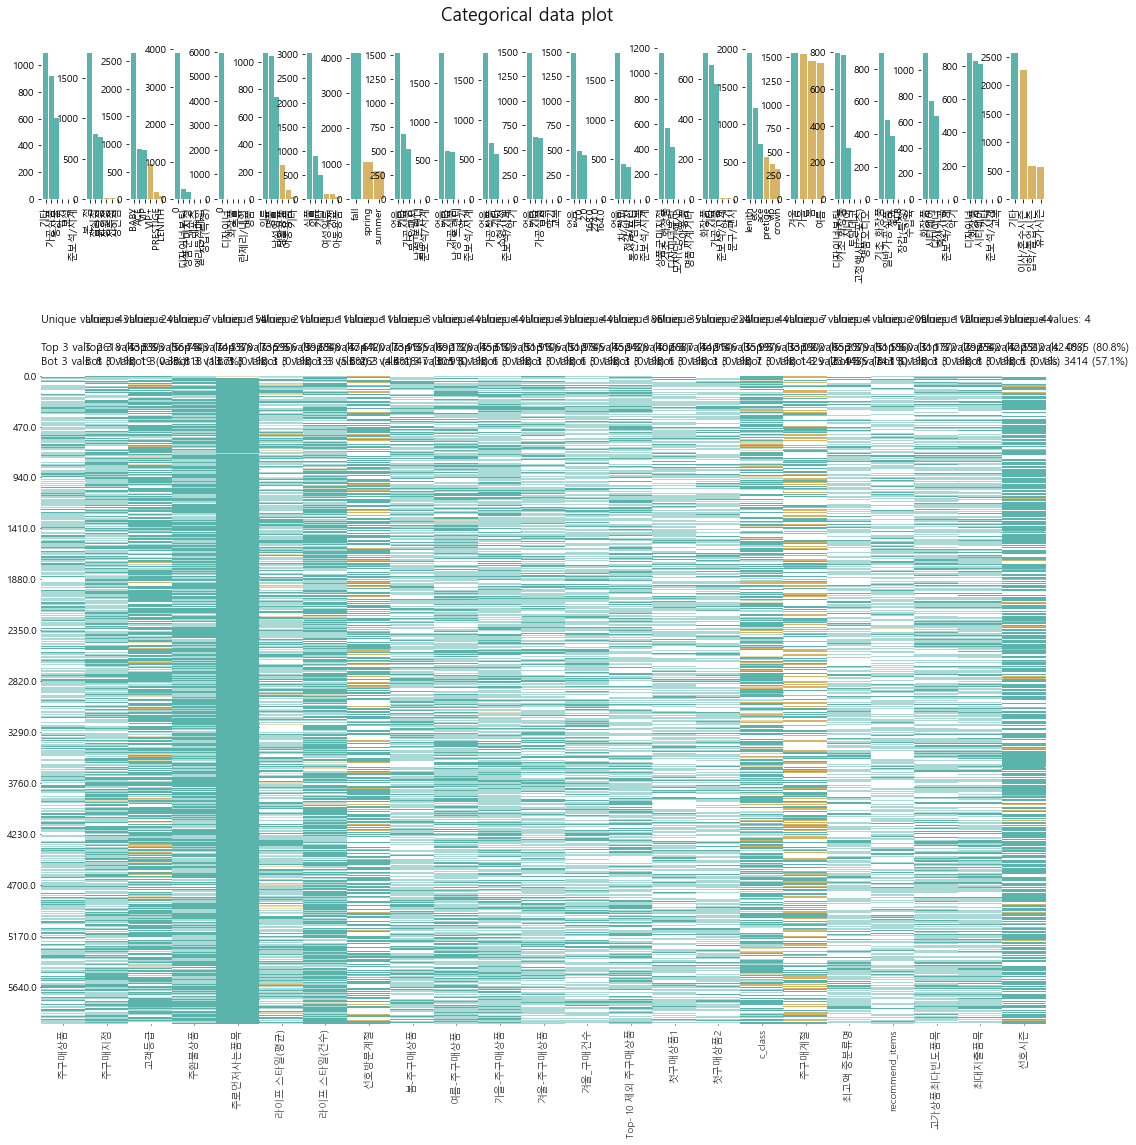

In [6]:
# 범주형 속성 파악

klib.cat_plot(features)

Displaying absolute correlations above the threshold (0.3). Specify a positive "threshold" to limit the results further.


<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

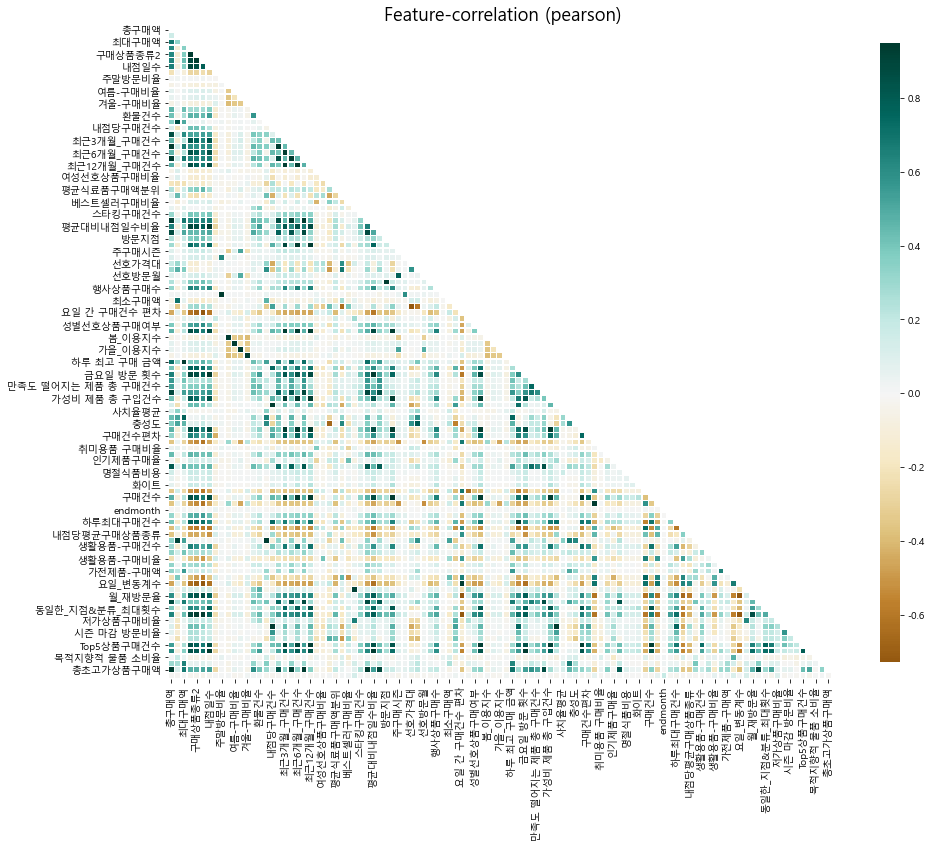

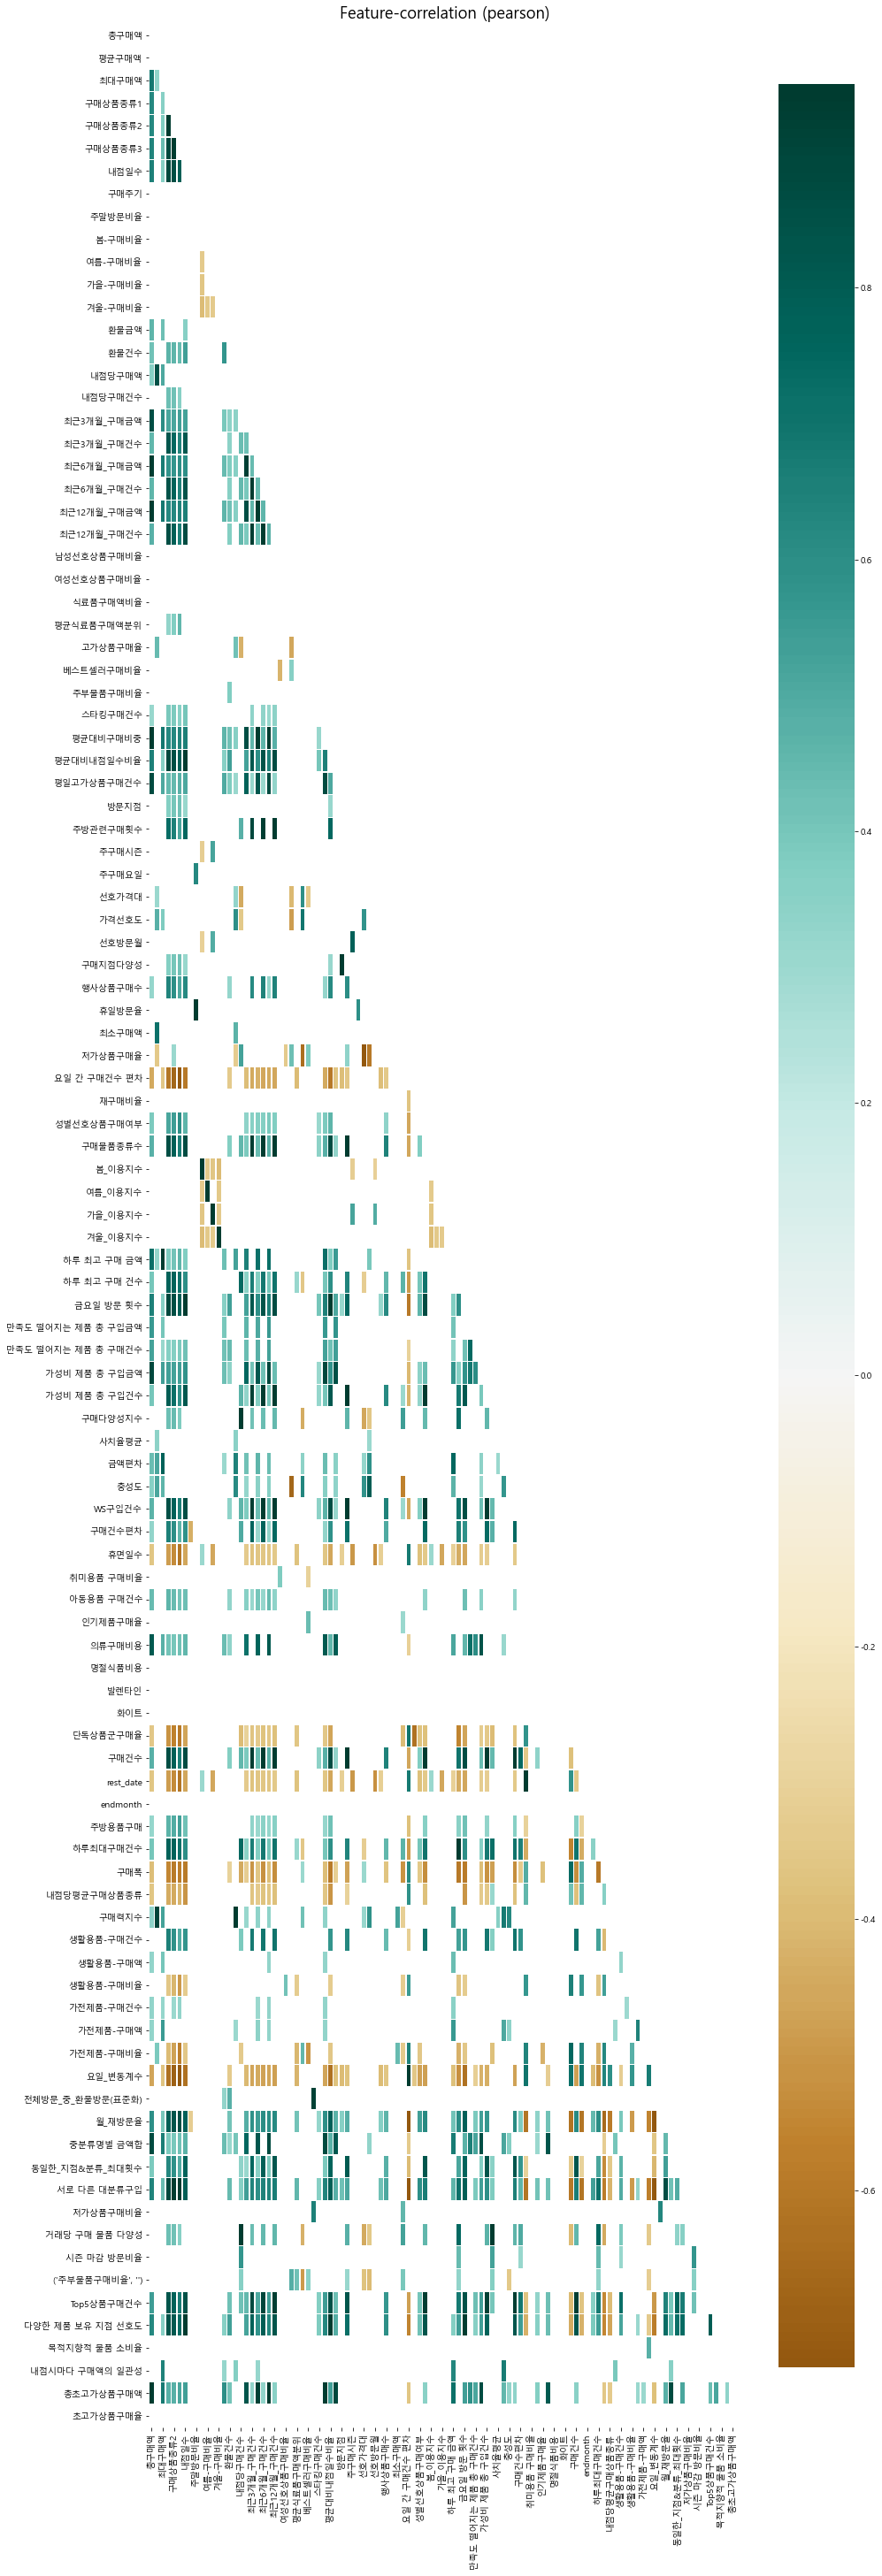

In [7]:
# 속성간 유사성 파악

klib.corr_plot(features, annot=False, figsize=(15,12))
klib.corr_plot(features, split='high', annot=False, figsize=(15,50))

<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

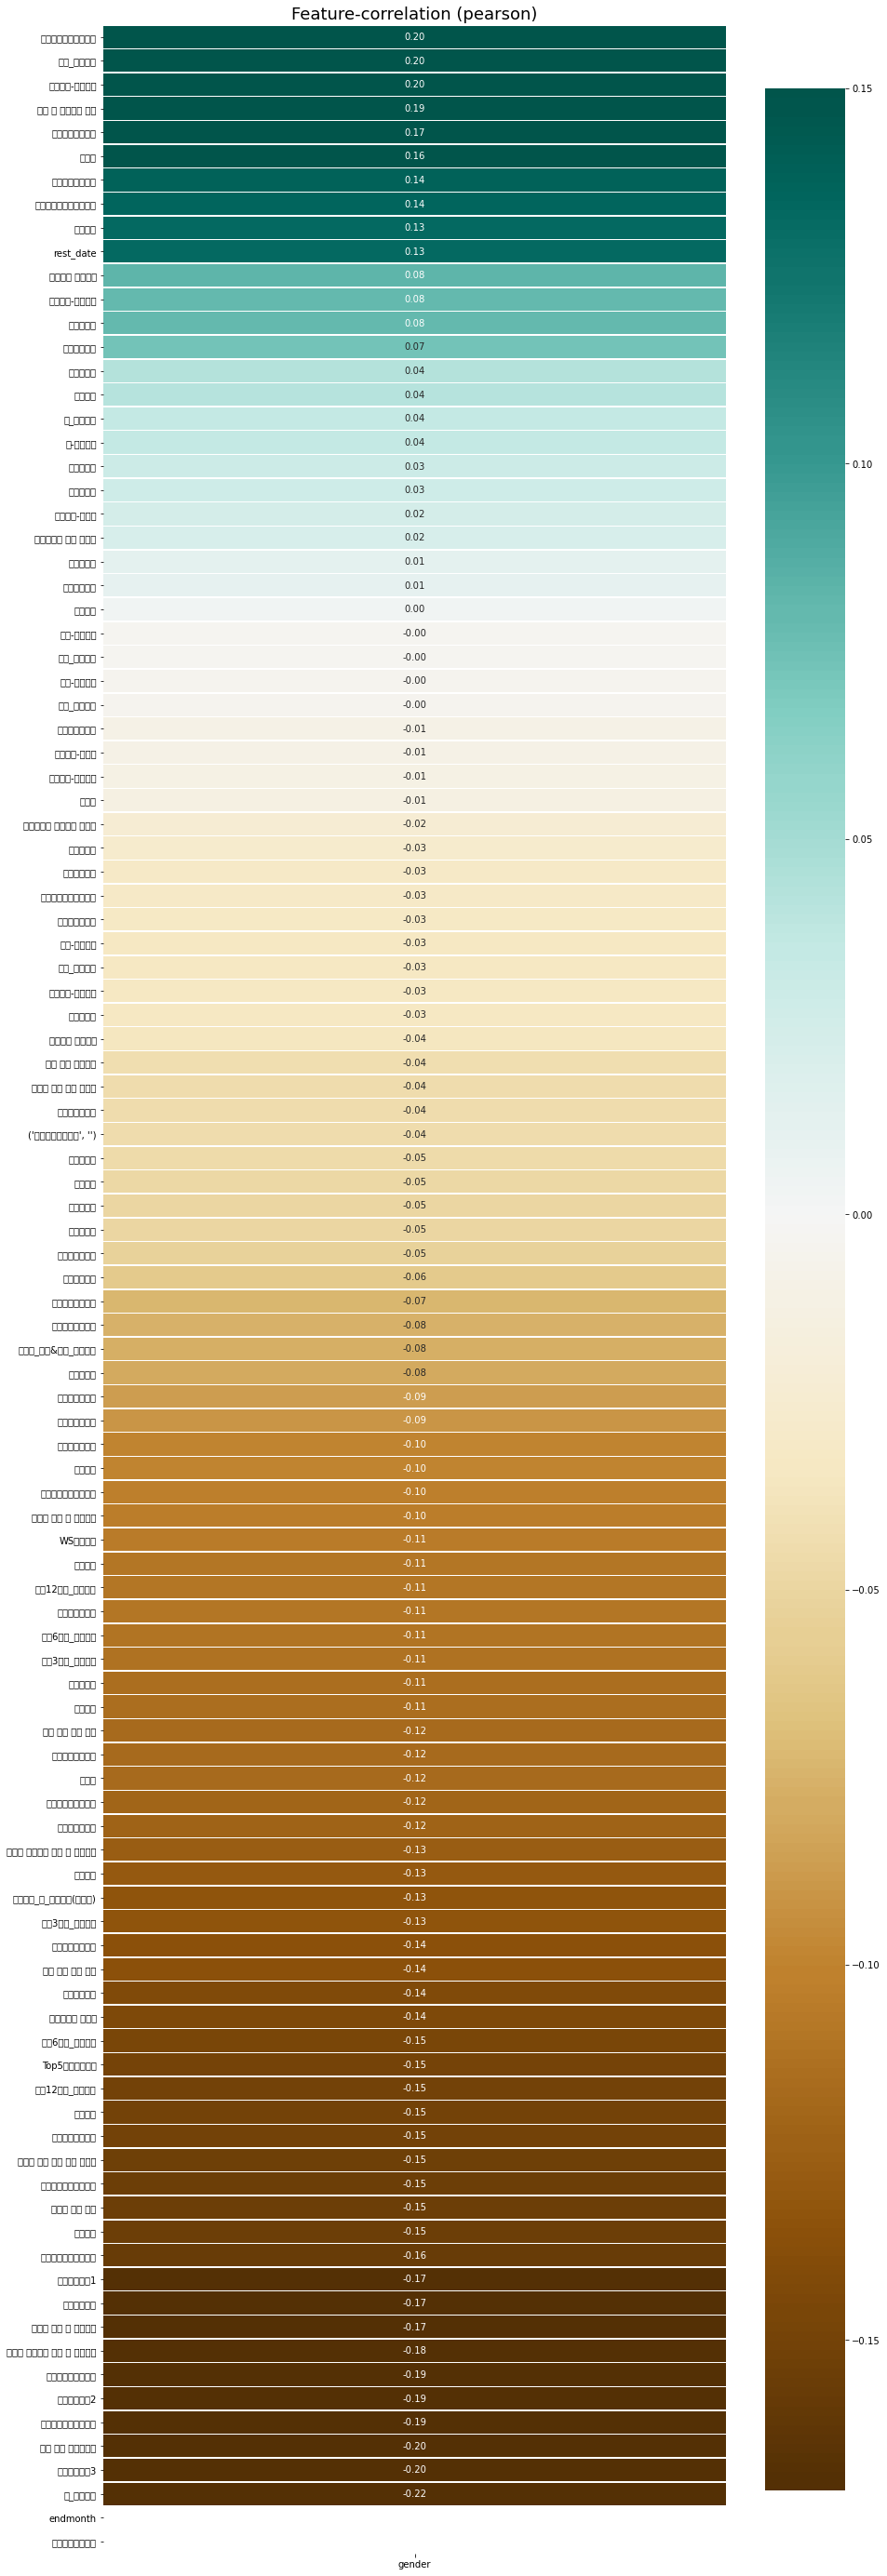

In [7]:
# 속성별 예측 능력 파악 
klib.corr_plot(pd.concat([train, y_train], axis=1), target='gender',figsize=(15,50))

In [9]:
del features["발렌타인"]
del features["겨울-구매비율"]
del features["겨울_이용지수"]
del features["여름-구매비율"]
del features["여름_이용지수"]
del features["평균구매액"]
del features["명절식품비용"]
del features["고가상품구매율"]
del features["화이트"]

### 3. Data Cleansing & Feature Engineering

In [10]:
# 범주형 변수와 수치형 변수를 분리
cat_features = features.select_dtypes(include=['object']).columns.to_list()
num_features = features.select_dtypes(exclude='object').columns.to_list()

*Impute Missing Values*

In [11]:
# 전체 피처데이터에서 inf값을 NaN으로 변경
features = features.replace([np.inf, -np.inf], np.nan) 

In [12]:
# 수치형 변수에 SimpleImputer를 이용해 결측값을 0으로 변경
features[num_features] = SimpleImputer(strategy='constant', fill_value=0).fit_transform(features[num_features])

In [13]:
# 범주형 범수 중 결측값이 존재하는 열 확인
features[cat_features].isnull().sum()

주구매상품                 0
주구매지점                 0
고객등급                  0
주환불상품                 0
주로먼저사는품목              0
라이프 스타일(평균)           0
라이프 스타일(건수)           0
선호방문계절                0
봄-주구매상품               0
여름-주구매상품              0
가을-주구매상품              0
겨울-주구매상품              0
겨울_구매건수               0
Top- 10 제외 주구매상품      0
첫구매상품1                0
첫구매상품2                0
c_class               0
주구매계절                 0
최고액 중분류명              0
recommend_items       0
고가상품최다빈도품목          632
최대지출품목                0
선호시즌                  0
dtype: int64

In [14]:
# 결측값이 존재하는 '고가상품최다빈도품목' 열 확인
features['고가상품최다빈도품목']

0          화장품
1        트래디셔널
2       남성 캐주얼
3          캐주얼
4           보석
         ...  
5977        골프
5978       NaN
5979    남성 캐주얼
5980        육류
5981       NaN
Name: 고가상품최다빈도품목, Length: 5982, dtype: object

In [15]:
# 결측값을 '없음'으로 변경
features['고가상품최다빈도품목'] = features['고가상품최다빈도품목'].fillna('없음')

*Deal with Outliers*

In [16]:
# 수치형 변수에 대해 상위 10% 이상, 하위 9% 이하 이상치 값을 각각 상위 10% 하위 9% 값으로 변경
features[num_features] = features[num_features].apply(lambda x: x.clip(x.quantile(.09), x.quantile(.90)), axis=0)

*Transform Features*

In [17]:
# 수치형 변수를 Powertransformer이용해 정규분포에 가깝게 만들기
features[num_features] = PowerTransformer(standardize=True).fit_transform(features[num_features])
features

,총구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,가을-구매비율,...,recommend_items,고가상품최다빈도품목,최대지출품목,Top5상품구매건수,선호시즌,다양한 제품 보유 지점 선호도,목적지향적 물품 소비율,내점시마다 구매액의 일관성,총초고가상품구매액,초고가상품구매율
0,0.535675,0.141443,0.959874,0.888588,1.011108,0.655979,0.298082,1.043448,-0.601604,0.930307,...,농산가공,화장품,화장품,1.052830,이사/혼수시즌,1.081023,-0.487964,0.457129,0.569873,0.278302
1,-1.193234,-0.962414,-1.160627,-1.253041,-1.194574,-1.003228,-1.229361,-1.314905,-1.310773,1.586057,...,시티캐주얼,트래디셔널,트래디셔널,-1.507728,이사/혼수시즌,0.346531,-0.487964,-0.308716,-1.585405,-1.441795
2,-1.026951,-1.105439,-1.477291,-1.253041,-1.194574,-1.003228,-1.229361,-1.314905,-1.310773,-1.241225,...,비지니스군,남성 캐주얼,남성 캐주얼,-0.707886,기타,-0.229972,-0.487964,-0.859145,-1.585405,-1.441795
3,-0.274096,-0.454339,0.628339,0.536001,0.627638,0.612472,0.244384,0.329659,1.432618,-0.456092,...,햄,캐주얼,침구/수예,0.577294,이사/혼수시즌,1.048266,-0.487964,-0.046958,0.067026,-0.231969
4,0.040259,0.785664,-1.160627,-1.021356,-0.913713,-1.003228,1.505189,-1.314905,0.625203,1.586057,...,시니어,보석,보석,-0.707886,기타,0.346531,2.160856,1.072642,0.364855,0.907601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,0.652969,0.784743,-0.262419,-0.418730,-0.131165,-0.029744,1.182094,1.362687,-0.760070,0.501197,...,시티웨어,골프,시티웨어,-0.332268,기타,-1.082047,-0.487964,0.823454,0.671491,0.572194
5978,-1.593777,-1.657582,-1.477291,-1.562504,-1.552257,-1.371529,-1.537583,-1.314905,-1.310773,-1.241225,...,니 트,없음,섬유잡화,-1.507728,기타,-1.082047,-0.487964,-1.816435,-1.585405,-1.441795
5979,1.420217,0.850950,1.033636,0.888588,1.180477,0.655979,0.349726,1.620578,-0.227759,-0.204034,...,기초 화장품,남성 캐주얼,남성 캐주얼,0.102884,기타,-1.082047,2.160856,1.041773,1.087163,0.447196
5980,0.699825,0.534343,-0.173090,-0.418730,-0.475365,-0.384922,1.505189,0.785323,0.393084,0.461962,...,일반가공식품,육류,육류,-1.507728,이사/혼수시즌,-1.082047,-0.487964,0.761811,0.701768,0.607419


*Encode Categorical Variables*

In [18]:
# 범주형 변수에 One-Hot-Encoding 후 수치형 변수와 병합
if len(cat_features) > 0:
    features = pd.concat([features[num_features], pd.get_dummies(features[cat_features])], axis=1)
features

,총구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,봄-구매비율,가을-구매비율,...,최대지출품목_캐주얼,최대지출품목_커리어,최대지출품목_통신/컴퓨터,최대지출품목_트래디셔널,최대지출품목_피혁잡화,최대지출품목_화장품,선호시즌_기타,선호시즌_이사/혼수시즌,선호시즌_입학/졸업시즌,선호시즌_휴가시즌
0,0.535675,0.141443,0.959874,0.888588,1.011108,0.655979,0.298082,1.043448,-0.601604,0.930307,...,0,0,0,0,0,1,0,1,0,0
1,-1.193234,-0.962414,-1.160627,-1.253041,-1.194574,-1.003228,-1.229361,-1.314905,-1.310773,1.586057,...,0,0,0,1,0,0,0,1,0,0
2,-1.026951,-1.105439,-1.477291,-1.253041,-1.194574,-1.003228,-1.229361,-1.314905,-1.310773,-1.241225,...,0,0,0,0,0,0,1,0,0,0
3,-0.274096,-0.454339,0.628339,0.536001,0.627638,0.612472,0.244384,0.329659,1.432618,-0.456092,...,0,0,0,0,0,0,0,1,0,0
4,0.040259,0.785664,-1.160627,-1.021356,-0.913713,-1.003228,1.505189,-1.314905,0.625203,1.586057,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,0.652969,0.784743,-0.262419,-0.418730,-0.131165,-0.029744,1.182094,1.362687,-0.760070,0.501197,...,0,0,0,0,0,0,1,0,0,0
5978,-1.593777,-1.657582,-1.477291,-1.562504,-1.552257,-1.371529,-1.537583,-1.314905,-1.310773,-1.241225,...,0,0,0,0,0,0,1,0,0,0
5979,1.420217,0.850950,1.033636,0.888588,1.180477,0.655979,0.349726,1.620578,-0.227759,-0.204034,...,0,0,0,0,0,0,1,0,0,0
5980,0.699825,0.534343,-0.173090,-0.418730,-0.475365,-0.384922,1.505189,0.785323,0.393084,0.461962,...,0,0,0,0,0,0,0,1,0,0


*Select Features*

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [02:38<00:00,  1.98s/it]

(21, 0.752369749045281)


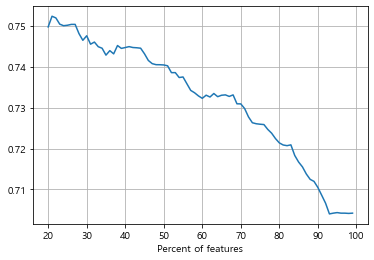

In [20]:
# 학습용과 제출용 데이터로 분리
features = pd.concat([pd.concat([train_id, test_id]).reset_index(drop=True), features], axis=1)
X_train = features.query('cust_id in @train_id').drop('cust_id', axis=1)
X_test = features.query('cust_id in @test_id').drop('cust_id', axis=1)

# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LogisticRegression(random_state=0)

#StartifiedKFold 정의
sfk = StratifiedKFold(n_splits = 7)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = [] # 스코어를 저장할 리스트 생성
for p in tqdm(range(20,100,1)): # 추출할 피처의 개수 범위를 (20~100)%의 구간에서 1%씩 올려가며 실행
    X_new = SelectPercentile(percentile=p).fit_transform(X_train, y_train)    
    cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=sfk).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [ ]:
# 최고 Score 를 가지는 p값 적용 
fs = SelectPercentile(percentile=best_score[0]).fit(X_train, y_train)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

print(X_train.shape)
print(features.iloc[:,1:].columns[fs.get_support()].tolist())

### 5. Model Tuning (Hyperparameter Optimization)

In [ ]:
# 학습데이터 70%, 평가데이터 30%로 데이터 분할
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.3, stratify = y_train, random_state=0)

In [ ]:
clfs = [
    (
        KNeighborsClassifier(),                    
        {'n_neighbors': range(1,51),        
         'weights': ['uniform', 'distance'],
         'metric': ['minkowski', 'euclidean', 'manhattan']}
    ),
#    (
#        DecisionTreeClassifier(random_state=0), 
#       {'max_depth' : [2,3]}                    
#    ),
    (
        XGBClassifier(random_state=0),       
        {'n_estimators': range(10, 310, 10),     
         'max_depth': range(1, 10, 1), 
         'eta':[0, 0.5, 0.001] , 
         'gamma' :np.arange(0.001,10,0.001),
         'subsample': [0.2, 0.3, 0.5, 0.7, 0.9, 1],
         'colsample_bytree': [0.5, 0.7, 0.9, 1],
          'min_child_weight': [1, 2, 3, 4]
        } 
    ),
#    (
#        AdaBoostClassifier(random_state=0),       
#        {'n_estimators' : [50,100,500,1000,3000], 
#         'learning_rate' : np.arange(0.1, 1, 0.1), 
#         'algorithm' : ['SAMME', 'SAMME.R']}
#    ),
    (
        MLPClassifier(random_state=0),  
        {'batch_size': [32, 64, 128],   
         'learning_rate' : ['constant', 'adaptive', 'invscaling'],
         'activation': ['tanh', 'relu', 'logistic'],
         'solver': ['sgd', 'adam'],
         'alpha': [1e-07,1e-06,0.0001,0.001,0.01,0.0005,0.005,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.7,0.9],
         'hidden_layer_sizes': [(32,),(64,),(128,),(32,16),(64,32,16)]} 
    ),        
    (
        LogisticRegression(random_state=0), 
        {'C': np.arange(0.0, 10, 0.001), 
         'penalty': ['l1','l2']}
    ),
    (
        RandomForestClassifier(random_state=0),
        {'n_estimators': range(10, 310, 10),
         'max_depth': range(1, 12),
         'min_impurity_decrease': [0,0.0001,0.001,0.01,0.0002,0.002,0.02,0.0005,0.005,0.05,0.1,0.2,0.3,0.4,0.5],
         'max_features': ['auto', 'sqrt', 'log2'],
         'bootstrap': [True, False],
         'criterion': ['gini', 'entropy'], 
         'class_weight': ['balanced', 'balanced_subsample', {}],
         'min_samples_split': [2, 5, 7, 9, 10],
         'min_samples_leaf': [2, 3, 4, 5, 6]}
    ),
    (
        GradientBoostingClassifier(random_state=0),
        {'n_estimators': range(10, 310, 10),
         'learning_rate': np.arange(0.0, 0.501, 0.001),
         'min_samples_split': [2, 4, 5, 7, 9, 10],
         'min_samples_leaf': [1, 2, 3, 4, 5],
         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
         'min_impurity_decrease': [0,0.0001,0.001,0.01,0.0002,0.002,0.02,0.0005,0.005,0.05,0.1,0.2,0.3,0.4,0.5],
         'max_features': ['auto', 'sqrt', 'log2']}
    ),
#    (
#        SVC(probability = True), 
#        {'kernel' : ["linear", "poly"], 
#         'C' : np.arange(0.01, 5, 0.01),
#         'gamma' : np.arange(0.5, 10, 0.1)}
#    )
]

clfs_tuned = []  # 튜닝된 모델을 저장
for clf, param_grid in tqdm(clfs):
    start = time.time()
    clf_name = type(clf).__name__
    iterations = 10 if clf_name in ['MLPClassifier'] else 30
    rand_search = RandomizedSearchCV(clf, param_grid, n_iter=iterations, scoring='roc_auc', 
                                     cv=sfk, random_state=0, n_jobs=-1)
    rand_search.fit(X_train, y_train)
    clf_score = rand_search.score(X_dev, y_dev)
    print('{:30s} {:30f} {:.1f}'.format(clf_name, clf_score, time.time() - start))
    clfs_tuned.append((clf_name, rand_search, clf_score))            

### 6. Model Ensemble

*Correlation between models*

In [ ]:
pred_results = []
for name, clf, clf_score in clfs_tuned:
    pred = clf.predict_proba(X_dev)[:,1]
    name = f'{name} \n({clf_score:.4f})'
    pred_results.append(pd.Series(pred, name=name))
ensemble_results = pd.concat(pred_results, axis=1)

# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

In [ ]:
# Mean agreement
(ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)

In [ ]:
corr = (ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)
names = corr.index
aucs = np.array(corr.index.str[-7:-1]).astype(float)
df = pd.DataFrame({'model': names, 'auc': aucs, 'cor': corr})        

plt.figure(figsize=(8,6))
g = sns.scatterplot(x="cor", y="auc", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.auc[line]-0.003, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.auc.min()-0.01,df.auc.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('ROC-AUC')
plt.grid()
plt.show()

*Averaging Ensemble*

In [ ]:
# 모델 개별 Score와 모델 간 상관관계를 고려하여 Averaging 앙상블에 사용하지 않을 모델은 주석 처리
selected = [
   'KNeighborsClassifier',
#  'DecisionTreeClassifier'
   'MLPClassifier',
   'LogisticRegression', 
   'RandomForestClassifier',
#   'AdaBoostClassifier'
   'GradientBoostingClassifier',
   'XGBClassifier'
#   'SVC'
]
models_for_ensemble = [clf for clf in clfs_tuned if clf[0] in selected]

In [ ]:
max_score = 0
for p in tqdm([0, 1, 2.56]):  # p==1:산술평균, p=0:기하평균, 그 외:멱평균(주의:멱평균은 과적합 가능성이 높음)    
    for i in range(2, len(models_for_ensemble)+1):
        for models in combinations(models_for_ensemble, i):
            if p == 0:
                pred_mean = gmean([clf.predict_proba(X_dev)[:,1] for name, clf, _ in models], axis=0)
            else:
                preds = [clf.predict_proba(X_dev)[:,1]
                         for name, clf, _ in models]
                pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(models))**(1/p)
            score = roc_auc_score(y_dev, pred_mean)
            if max_score < score:
                best_avg_ensemble = (p, models, score)
                max_score = score

p, models, score = best_avg_ensemble
print('p={}\n{}\n{}'.format(p, '●'.join([clf_name for clf_name, _, _ in models]), score))

In [ ]:
# sklearn의 다른 classifier와 호환성을 갖기위해 Custom Classifier인 "AveragingClassifier" 생성

class AveragingClassifier(ClassifierMixin):
    def __init__(self, estimators, p):
        self.estimators = estimators
        self.p = p
    
    def fit(self, X, y):
        return None

    def predict(self, X):
        if self.p == 0:
            pred = gmean([clf.predict(X) for name, clf in self.estimators], axis=0)
        else:
            preds = [clf.predict(X) for name, clf in self.estimators]
            pred = (np.sum(np.array(preds)**self.p, axis=0) / len(self.estimators))**(1/self.p)
        return pred
         
    def predict_proba(self, X):
        if self.p == 0:
            prob = gmean([clf.predict_proba(X) for name, clf in self.estimators], axis=0)
        else:
            probs = [clf.predict_proba(X) for name, clf in self.estimators]
            prob = (np.sum(np.array(probs)**self.p, axis=0) / len(self.estimators))**(1/self.p)
        return prob
    
estimators = [(name, clf) for name, clf, _ in models]
avg_clf = AveragingClassifier(estimators, p)
avg_clf.fit(X_train, y_train)    

### 7. Deployment

In [ ]:
# Averaging ensemble을 적용한 submission
pd.DataFrame({'cust_id': test_id, 'gender': avg_clf.predict_proba(X_test)[:,1]}).to_csv('../dat/submissions1/submission_1.csv', index=False)

<font color="#CC3D3D"><p>
# End